### Diffusion
데이터를 만들어내는 deep generative model이다. 유한한 시간 뒤에 이미지를 생성하는 variational inference를 통해 훈련된 Markov chain을 parameterized한 형태라고도 한다.

<h4 style="color: red;">※ Markov chain</h4>
이전의 샘플링이 현재 샘플링에 영향을 미치는 $p(x|x)$ 형식을 의미한다.

### Simple Architecture
아래 그림의 $X_0$는 실제 데이터, $X_T$는 최종 노이즈, 그 사이의 $X_t$는 데이터가 noise가 더해진 상태의 latent variable을 의미한다. 

<div align=center><img src="./image_for_markdown/diffusion.png"></div>

- forward process(diffusion process) as q: data로부터 noise를 조금씩 더해 가면서 data를 완전한 noise로 만든다.
    + 위 그림에서 $X_0$에 노이즈를 더해 $X_1$을 만드는 것은 $q(X_1|X_0)$ 로 표현할 수 있다. 이를 time t에 대해 general하게 표현한다면 $q(X_t|X_t-1)$ 로 표현할 수 있다. 이 때 끝까지 가면 $X_T$ 즉, 완전히 destroy된 형태가 나온다. 이는 Normal Distribution $N(X_T; 0, I)$을 따른다.
- reverse process as p: forward process로부터 전달된 noise를 조금씩 복원해가면서 data로 복원한다.
    + q 과정과는 반대로 노이즈를 걷어내는 denosing process이다. 그래서 $q(X_t|X_t-1)$로 표현되던 것과는 반대로 time이 뒤바뀐 $p(X_t-1|X_t)$로 표현된다.

전체적으로 보자면, 그림의 오른쪽에서 왼쪽 방향으로 noise를 점점 더해가는 **forward process** q를 진행한다. 그리고 이 forward process를 반대로 추정하는 **reverse process** p를 학습함으로서 $noise(X_T)$로부터 우리가 원하는 이미지, 텍스트, 그래프 등을 generate할 수 있는 모델을 만들어 내는 것이다.

그리고 이를 통해 결국, 우리는 실제 data의 분포인 $p(X_0)$를 찾아내는것을 목적으로 한다.

In [25]:
!conda activate tti

In [1]:
import torch

torch.cuda.is_available()

True

### Training with Diffuser
torch 기반 diffuser모델을 hugging face에서 제공하는 라이브러리를 이용해서 학습해보자.

Hugging Face에서 제공하는 라이브러리를 사용할 예정이기에 로그인을 진행한다.

In [2]:
from huggingface_hub import notebook_login

notebook_login()

### Training Parameter 설정
훈련 시 사용할 여러 파라미터들을 설정한다.

In [3]:
from dataclasses import dataclass

@dataclass
class TrainingConfig:
    image_size = 128  # 생성되는 이미지의 사이즈
    train_batch_size = 16  # batch size of train set
    eval_batch_size = 16  # batch size of validation set
    num_epochs = 50  # epochs
    gradient_accumulation_steps = 1
    learning_rate = 1e-4  # learning rate
    lr_warmup_steps = 500
    save_image_epochs = 10  
    save_model_epochs = 30
    mixed_precision = "fp16"  # float32의 경우 "no", automatic mixed precision의 경우 "fp16"
    output_dir = "generated_image"  # 생성된 이미지가 저장될 경로

    push_to_hub = False  # 학습한 모델을 hub에 올릴지 여부
    hub_private_repo = False  
    overwrite_output_dir = False  # 새로 학습된 모델을 이전 모델에 덮어쓸지에 대한 여부
    seed = 0

config = TrainingConfig()

### Load Dataset
이 또한 Hugging face에서 제공하는 나비 데이터셋을 사용할 예정이다.

In [4]:
from datasets import load_dataset

config.dataset_name = "huggan/smithsonian_butterflies_subset"
dataset = load_dataset(config.dataset_name, split="train")

C:\Users\admin\miniconda3\envs\tti\lib\site-packages\huggingface_hub\repocard.py:105: UserWarning: Repo card metadata block was not found. Setting CardData to empty.
  warnings.warn("Repo card metadata block was not found. Setting CardData to empty.")


dataset을 살펴보면 이미지 url 부터 각 나비 개체들의 이름, 성별, 지역 등등의 정보를 담고 있는 형태를 가진다.

In [5]:
dataset

Dataset({
    features: ['image_url', 'image_alt', 'id', 'name', 'scientific_name', 'gender', 'taxonomy', 'region', 'locality', 'date', 'usnm_no', 'guid', 'edan_url', 'source', 'stage', 'image', 'image_hash', 'sim_score'],
    num_rows: 1000
})

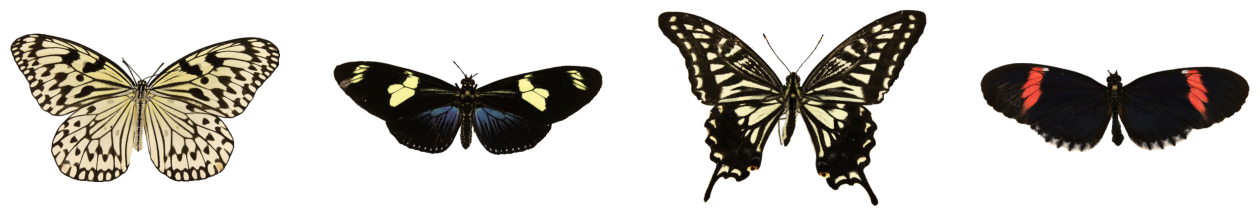

In [6]:
import matplotlib.pyplot as plt

fig, axis = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["image"]):
    axis[i].imshow(image)
    axis[i].set_axis_off()

plt.show()

### Preprocess Images
이미지의 크기가 다 제각기이기에, 전처리를 수행한다.

- Resize : 이미지의 크기를 재조정, 여기서는 config class에서 지정한 크기를 한 변으로 하게끔 조절한다.
- RandomHorizontalFlip : 이미지를 무작위로 수평방향으로 뒤집어 데이터셋을 증강한다.
- Normalize : 이미지 정규화

In [7]:
from torchvision import transforms

preprocess = transforms.Compose(
    [
        transforms.Resize((config.image_size, config.image_size)),  # image resize
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5], [0.5]),
    ]
)

set_transform을 이용하면 증강 및 전처리 작업에 대한 결과를 즉시 적용할 수 있다.

In [8]:
def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}

dataset.set_transform(transform)

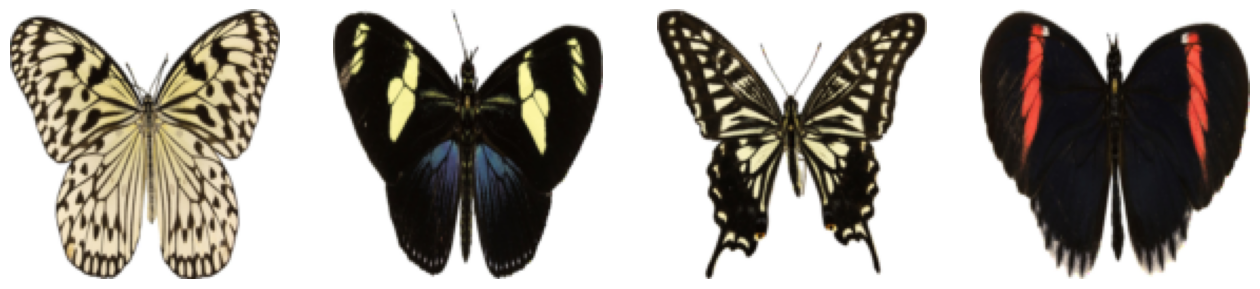

In [9]:
fig, axis = plt.subplots(1, 4, figsize=(16, 4))
for i, image in enumerate(dataset[:4]["images"]):
    axis[i].imshow(image.permute(1, 2, 0).numpy() / 2 + 0.5)
    axis[i].set_axis_off()

plt.show()

### Load Model
이미지의 크기를 모두 동일하게 변환하고, 약간의 증강 기법까지 적용하였으니 모델을 불러오자.

In [10]:
import torch

train_dataloader = torch.utils.data.DataLoader(dataset, batch_size = config.train_batch_size, shuffle=True)

In [11]:
from diffusers import UNet2DModel


model = UNet2DModel(
    sample_size=config.image_size,  # the target image resolution
    in_channels=3,  # the number of input channels, 3 for RGB images
    out_channels=3,  # the number of output channels
    layers_per_block=2,  # how many ResNet layers to use per UNet block
    block_out_channels=(128, 128, 256, 256, 512, 512),  # the number of output channes for each UNet block
    down_block_types=( 
        "DownBlock2D",  # a regular ResNet downsampling block
        "DownBlock2D", 
        "DownBlock2D", 
        "DownBlock2D", 
        "AttnDownBlock2D",  # a ResNet downsampling block with spatial self-attention
        "DownBlock2D",
    ), 
    up_block_types=(
        "UpBlock2D",  # a regular ResNet upsampling block
        "AttnUpBlock2D",  # a ResNet upsampling block with spatial self-attention
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D", 
        "UpBlock2D"  
      ),
)

In [12]:
sample_image = dataset[0]['images'].unsqueeze(0)  # unsqueeze : 1인 차원을 생성
print('Input shape:', sample_image.shape)  # 가로 세로가 128px인 컬러사진 1장

Input shape: torch.Size([1, 3, 128, 128])


In [13]:
print('Output shape:', model(sample_image, timestep=0).sample.shape)

Output shape: torch.Size([1, 3, 128, 128])


### DDPM
diffusion task를 수행할 때, forward process를 진행하는 방식이 다르다. 이번에는 DDPM(Denoising Diffusion Probabilistic Models)에서 제안된 훈련 알고리즘과 노이즈제거 훈련에 해당하는 DDPMSchedular를 사용한다.

In [14]:
from diffusers import DDPMScheduler

noise_scheduler = DDPMScheduler(num_train_timesteps=1000)

DDPM이 어떤 노이즈를 발생하는지 시각화 해보자.

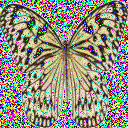

In [15]:
import torch
from PIL import Image

noise = torch.randn(sample_image.shape)
timesteps = torch.LongTensor([50])
noisy_image = noise_scheduler.add_noise(sample_image, noise, timesteps)

Image.fromarray(((noisy_image.permute(0, 2, 3, 1) + 1.0) * 127.5).type(torch.uint8).numpy()[0])

In [16]:
import torch.nn.functional as F

noise_pred = model(noisy_image, timesteps).sample
loss = F.mse_loss(noise_pred, noise)

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr = config.learning_rate)

In [18]:
from diffusers.optimization import get_cosine_schedule_with_warmup

lr_scheduler = get_cosine_schedule_with_warmup(
    optimizer = optimizer,
    num_warmup_steps = config.lr_warmup_steps,
    num_training_steps = (len(train_dataloader) * config.num_epochs),
)

In [19]:
from diffusers import DDPMPipeline

import math

def make_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i%cols*w, i//cols*h))
    return grid

def evaluate(config, epoch, pipeline):
    # Sample some images from random noise (this is the backward diffusion process).
    # The default pipeline output type is `List[PIL.Image]`
    images = pipeline(
        batch_size = config.eval_batch_size, 
        generator=torch.manual_seed(config.seed),
    ).images

    # Make a grid out of the images
    image_grid = make_grid(images, rows=4, cols=4)

    # Save the images
    test_dir = os.path.join(config.output_dir, "samples")
    os.makedirs(test_dir, exist_ok=True)
    image_grid.save(f"{test_dir}/{epoch:04d}.png")

In [20]:
from accelerate import Accelerator
from huggingface_hub import HfFolder, Repository, whoami

from tqdm.auto import tqdm
from pathlib import Path
import os

def get_full_repo_name(model_id: str, organization: str = None, token: str = None):
    if token is None:
        token = HfFolder.get_token()
    if organization is None:
        username = whoami(token)["name"]
        return f"{username}/{model_id}"
    else:
        return f"{organization}/{model_id}"

def train_loop(config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler):
    # Initialize accelerator and tensorboard logging
    accelerator = Accelerator(
        mixed_precision=config.mixed_precision,
        gradient_accumulation_steps=config.gradient_accumulation_steps, 
        log_with="tensorboard",
        project_dir=os.path.join(config.output_dir, "logs")
    )
    if accelerator.is_main_process:
        if config.push_to_hub:
            repo_name = get_full_repo_name(Path(config.output_dir).name)
            repo = Repository(config.output_dir, clone_from=repo_name)
        elif config.output_dir is not None:
            os.makedirs(config.output_dir, exist_ok=True)
        accelerator.init_trackers("train_example")
    
    # Prepare everything
    # There is no specific order to remember, you just need to unpack the 
    # objects in the same order you gave them to the prepare method.
    model, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
        model, optimizer, train_dataloader, lr_scheduler
    )
    
    global_step = 0

    # Now you train the model
    for epoch in range(config.num_epochs):
        progress_bar = tqdm(total=len(train_dataloader), disable=not accelerator.is_local_main_process)
        progress_bar.set_description(f"Epoch {epoch}")

        for step, batch in enumerate(train_dataloader):
            clean_images = batch['images']
            # Sample noise to add to the images
            noise = torch.randn(clean_images.shape).to(clean_images.device)
            bs = clean_images.shape[0]

            # Sample a random timestep for each image
            timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bs,), device=clean_images.device).long()

            # Add noise to the clean images according to the noise magnitude at each timestep
            # (this is the forward diffusion process)
            noisy_images = noise_scheduler.add_noise(clean_images, noise, timesteps)
            
            with accelerator.accumulate(model):
                # Predict the noise residual
                noise_pred = model(noisy_images, timesteps, return_dict=False)[0]
                loss = F.mse_loss(noise_pred, noise)
                accelerator.backward(loss)

                accelerator.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                lr_scheduler.step()
                optimizer.zero_grad()
            
            progress_bar.update(1)
            logs = {"loss": loss.detach().item(), "lr": lr_scheduler.get_last_lr()[0], "step": global_step}
            progress_bar.set_postfix(**logs)
            accelerator.log(logs, step=global_step)
            global_step += 1

        # After each epoch you optionally sample some demo images with evaluate() and save the model
        if accelerator.is_main_process:
            pipeline = DDPMPipeline(unet=accelerator.unwrap_model(model), scheduler=noise_scheduler)

            if (epoch + 1) % config.save_image_epochs == 0 or epoch == config.num_epochs - 1:
                evaluate(config, epoch, pipeline)

            if (epoch + 1) % config.save_model_epochs == 0 or epoch == config.num_epochs - 1:
                if config.push_to_hub:
                    repo.push_to_hub(commit_message=f"Epoch {epoch}", blocking=True)
                else:
                    pipeline.save_pretrained(config.output_dir) 

In [87]:
from accelerate import notebook_launcher
args = (config, model, noise_scheduler, optimizer, train_dataloader, lr_scheduler)

notebook_launcher(train_loop, args, num_processes=1)

Launching training on one GPU.


  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\admin\miniconda3\envs\tti\lib\site-packages\diffusers\pipelines\ddpm\pipeline_ddpm.py:89: FutureWarning: `generator.device == 'cpu'` is deprecated and will be removed in version 0.12.0. The `generator` device is `cpu` and does not match the pipeline device `cuda:0`, so the `generator` will be ignored. Please use `torch.Generator(device="cuda:0")` instead.
  deprecate(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\admin\miniconda3\envs\tti\lib\site-packages\diffusers\pipelines\ddpm\pipeline_ddpm.py:89: FutureWarning: `generator.device == 'cpu'` is deprecated and will be removed in version 0.12.0. The `generator` device is `cpu` and does not match the pipeline device `cuda:0`, so the `generator` will be ignored. Please use `torch.Generator(device="cuda:0")` instead.
  deprecate(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\admin\miniconda3\envs\tti\lib\site-packages\diffusers\pipelines\ddpm\pipeline_ddpm.py:89: FutureWarning: `generator.device == 'cpu'` is deprecated and will be removed in version 0.12.0. The `generator` device is `cpu` and does not match the pipeline device `cuda:0`, so the `generator` will be ignored. Please use `torch.Generator(device="cuda:0")` instead.
  deprecate(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\admin\miniconda3\envs\tti\lib\site-packages\diffusers\pipelines\ddpm\pipeline_ddpm.py:89: FutureWarning: `generator.device == 'cpu'` is deprecated and will be removed in version 0.12.0. The `generator` device is `cpu` and does not match the pipeline device `cuda:0`, so the `generator` will be ignored. Please use `torch.Generator(device="cuda:0")` instead.
  deprecate(


  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

  0%|          | 0/63 [00:00<?, ?it/s]

C:\Users\admin\miniconda3\envs\tti\lib\site-packages\diffusers\pipelines\ddpm\pipeline_ddpm.py:89: FutureWarning: `generator.device == 'cpu'` is deprecated and will be removed in version 0.12.0. The `generator` device is `cpu` and does not match the pipeline device `cuda:0`, so the `generator` will be ignored. Please use `torch.Generator(device="cuda:0")` instead.
  deprecate(


  0%|          | 0/1000 [00:00<?, ?it/s]

['generated_image/samples\\0009.png', 'generated_image/samples\\0019.png', 'generated_image/samples\\0029.png', 'generated_image/samples\\0039.png', 'generated_image/samples\\0049.png']


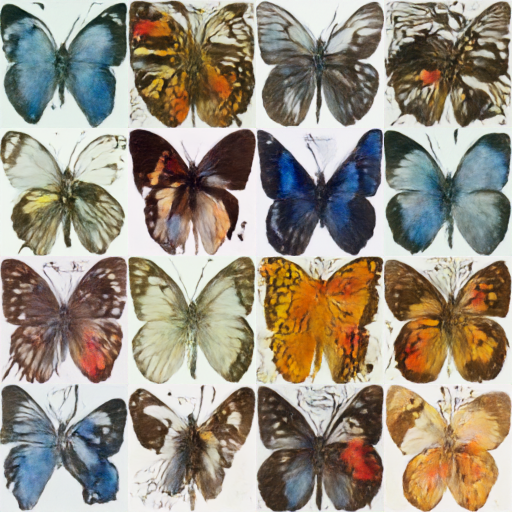

In [117]:
import glob

sample_images = sorted(glob.glob(f"{config.output_dir}/samples/*.png"))
print(sample_images)
Image.open(sample_images[-1])